In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [3]:
# imputed already
big_df = pd.read_csv('big_df_final.csv')
big_df.head()

,CUST_NUM,PROVINCE,REGION,EDUCATION,AGE,TENURE,BUSINESS_OWNER,DIGITAL_FLAG,INCOME_SOURCE,GENDER,...,DIGITAL_CHANNEL,DIGITAL_TRAN_TYPE,INCOMING_MEAN,INCOMING_COUNT,INCOMING_BPI_ACCT_TYPE,INCOMING_SRC_BANK_NAME,OUTGOING_MEAN,OUTGOING_COUNT,OUTGOING_CHANNEL,OUTGOING_RCV_BANK_NAME
0,11712.654012,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,20.0,1.833333,N,DIGITAL,ALLOWANCE,MALE,...,MOBILE,BILLS PAYMENT,2619.191451,5.0,SA,HUMAN,1626.116225,17.0,MOBILE,HUMAN
1,436.605085,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,21.0,4.250000,N,NO_DATA,SALARY,FEMALE,...,NO_DATA,NO_DATA,0.000000,0.0,NO_DATA,NO_DATA,0.000000,0.0,NO_DATA,NO_DATA
2,921.989154,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,23.0,2.000000,N,TRADITIONAL,ALLOWANCE,MALE,...,WEB,E-WALLET,3349.209339,4.0,SA,HUMAN,0.000000,0.0,NO_DATA,NO_DATA
3,1119.634762,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),LOW,13.0,5.583333,N,TRADITIONAL,ALLOWANCE,MALE,...,NO_DATA,NO_DATA,0.000000,0.0,NO_DATA,NO_DATA,0.000000,0.0,NO_DATA,NO_DATA
4,1709.755538,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,20.0,1.250000,N,DIGITAL,SALARY,FEMALE,...,WEB,E-WALLET,3886.745466,4.0,SA,CAT,0.000000,0.0,NO_DATA,NO_DATA


### Preprocessing

In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler, PowerTransformer

In [5]:
dfp = big_df.copy().drop('CUST_NUM', axis=1)

df_num = dfp.select_dtypes(exclude='object')
df_cat = dfp.select_dtypes(include='object')

In [6]:
no_data_counts = df_cat.apply(lambda col: col[col == 'NO_DATA'].count())
no_data_counts

PROVINCE                      0
REGION                        0
EDUCATION                 13229
BUSINESS_OWNER                0
DIGITAL_FLAG              13921
INCOME_SOURCE               608
GENDER                        0
MARITAL_STATUS                0
CREDIT_CHANNEL            43999
CREDIT_MERCH_GROUP        44010
DEBIT_CHANNEL             20526
DIGITAL_CHANNEL           35982
DIGITAL_TRAN_TYPE         35982
INCOMING_BPI_ACCT_TYPE    33214
INCOMING_SRC_BANK_NAME    33214
OUTGOING_CHANNEL          39912
OUTGOING_RCV_BANK_NAME    39912
dtype: int64

In [7]:
# Select only categorical columns with few 'NO_DATA'
# PROVINCE is not included anymore because of REGION
df_cat = df_cat[['REGION', 'EDUCATION', 'BUSINESS_OWNER', 'DIGITAL_FLAG', 'INCOME_SOURCE', 'GENDER', 'MARITAL_STATUS']]

# one-hot encoding
df_cat = pd.get_dummies(df_cat)
# combine scaled numerical and categorical dummy variables in a dataframe
dfp_combined = pd.concat([df_num, df_cat], axis=1)
# standardize the data to have a mean of ~0 and a variance of 1
dfp_scaled = StandardScaler().fit_transform(dfp_combined)

### Feature Selection (PCA)
Principal component analysis, or PCA, is a dimensionality reduction method that is often used to reduce the dimensionality of large data sets, by transforming a large set of variables into a smaller one that still contains most of the information in the large set.

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# principal components
pca = PCA(n_components=10)
res_pca = pca.fit_transform(dfp_scaled)

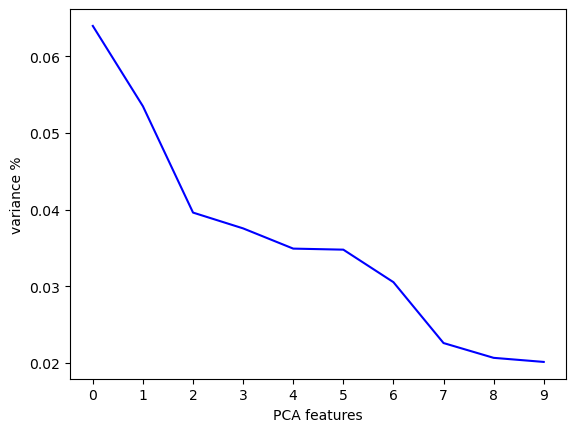

In [9]:
features = range(pca.n_components_)
plt.plot(features, pca.explained_variance_ratio_, color='blue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

By elbow method, we choose n=5

In [10]:
pca_final = PCA(n_components=5)
res_pca = pca_final.fit_transform(dfp_scaled)

In [11]:
dfp_pca = pd.DataFrame(res_pca)

### Model

In [11]:
import hdbscan

In [12]:
dfp_h = big_df.copy()

# 450 is approximately 1% of the cluster size
model = hdbscan.HDBSCAN(min_cluster_size=450, min_samples=3)
# model = HDBSCAN(min_cluster_size=4614, min_samples=3, metric='precomputed')
clusters = model.fit_predict(dfp_pca.astype(np.float64))

In [13]:
dfp_h.insert(0, 'CLUSTER', clusters)
dfp_h.head()

,CLUSTER,CUST_NUM,PROVINCE,REGION,EDUCATION,AGE,TENURE,BUSINESS_OWNER,DIGITAL_FLAG,INCOME_SOURCE,...,DIGITAL_CHANNEL,DIGITAL_TRAN_TYPE,INCOMING_MEAN,INCOMING_COUNT,INCOMING_BPI_ACCT_TYPE,INCOMING_SRC_BANK_NAME,OUTGOING_MEAN,OUTGOING_COUNT,OUTGOING_CHANNEL,OUTGOING_RCV_BANK_NAME
0,4,11712.654012,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,20.0,1.833333,N,DIGITAL,ALLOWANCE,...,MOBILE,BILLS PAYMENT,2619.191451,5.0,SA,HUMAN,1626.116225,17.0,MOBILE,HUMAN
1,3,436.605085,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,21.0,4.250000,N,NO_DATA,SALARY,...,NO_DATA,NO_DATA,0.000000,0.0,NO_DATA,NO_DATA,0.000000,0.0,NO_DATA,NO_DATA
2,4,921.989154,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,23.0,2.000000,N,TRADITIONAL,ALLOWANCE,...,WEB,E-WALLET,3349.209339,4.0,SA,HUMAN,0.000000,0.0,NO_DATA,NO_DATA
3,4,1119.634762,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),LOW,13.0,5.583333,N,TRADITIONAL,ALLOWANCE,...,NO_DATA,NO_DATA,0.000000,0.0,NO_DATA,NO_DATA,0.000000,0.0,NO_DATA,NO_DATA
4,3,1709.755538,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,20.0,1.250000,N,DIGITAL,SALARY,...,WEB,E-WALLET,3886.745466,4.0,SA,CAT,0.000000,0.0,NO_DATA,NO_DATA


In [14]:
import numpy as np
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
transformed = tsne.fit_transform(dfp_pca)

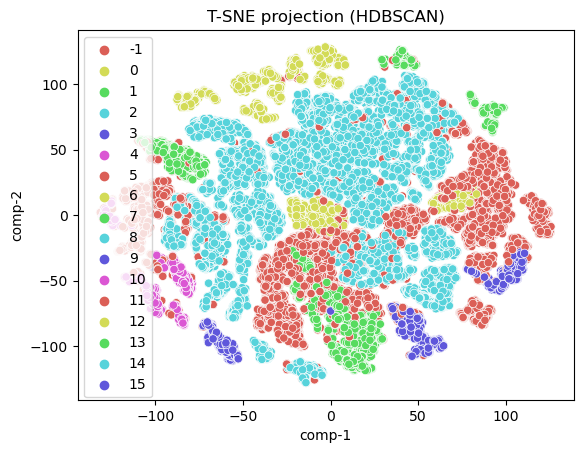

In [15]:
import seaborn as sns

dfp_hdbscan = pd.DataFrame()
dfp_hdbscan['CLUSTER'] = dfp_h['CLUSTER']
dfp_hdbscan['comp-1'] = transformed[:,0]
dfp_hdbscan['comp-2'] = transformed[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=dfp_hdbscan.CLUSTER.tolist(),
                palette=sns.color_palette('hls'),
                data=dfp_hdbscan).set(title="T-SNE projection (HDBSCAN)")

plt.savefig('T-SNE_HDBSCAN.png')
plt.show()

In [16]:
# X = dfp_hdbscan[['comp-1', 'comp-2']].to_numpy().astype(np.float64)
# hdbscan.validity_index(X, labels=clusters)

In [20]:
scores = []

# silhouette score is not a good metric for density-based clustering, use instead DBCV

def test_cluster(n):
    # create model
    dfp_h = big_df.copy()
    
    model = hdbscan.HDBSCAN(min_cluster_size = n, min_samples=3)
    clusters = model.fit_predict(dfp_pca)

    dfp_h.insert(0, 'CLUSTER', clusters)

    # plot
    dfp_hdbscan = pd.DataFrame()
    dfp_hdbscan['CLUSTER'] = dfp_h['CLUSTER']
    dfp_hdbscan['comp-1'] = transformed[:,0]
    dfp_hdbscan['comp-2'] = transformed[:,1]
    
    sns.scatterplot(x="comp-1", y="comp-2", hue=dfp_hdbscan.CLUSTER.tolist(),
                    palette=sns.color_palette('hls'),
                    data=dfp_hdbscan).set(title=f"T-SNE projection (HDBSCAN, min_cluster_size={n})")
    
    plt.savefig(f'hdbscan\T-SNE_HDBSCAN_{n}.png')
    plt.clf()

    scores.append([n,dfp_h.CLUSTER.nunique()])
    print(f'Done with min_cluster_size = {n}: {dfp_h.CLUSTER.nunique()} clusters')
    
    # if ind != 0 and dfp_h.CLUSTER.nunique() == scores[ind-1][1]:
    #     print(f'Done with min_cluster_size = {n}: {dfp_h.CLUSTER.nunique()} clusters')
    # else:
    #     print('... computing score')
    #     # compute score
    #     X = dfp_hdbscan[['comp-1', 'comp-2']].to_numpy().astype(np.float64)
    #     score = hdbscan.validity_index(X, labels=clusters)
    #     scores.append([n, dfp_h.CLUSTER.nunique(), score])

    #     print(f'Done with min_cluster_size = {n}: {dfp_h.CLUSTER.nunique()} clusters and score of {score}')

In [21]:
tests = [int(i) for i in np.linspace(450, 2500, num=10)]
tests

[450, 677, 905, 1133, 1361, 1588, 1816, 2044, 2272, 2500]

In [22]:
for test in tests:
    test_cluster(test)

Done with min_cluster_size = 450: 17 clusters
Done with min_cluster_size = 677: 5 clusters
Done with min_cluster_size = 905: 4 clusters
Done with min_cluster_size = 1133: 4 clusters
Done with min_cluster_size = 1361: 4 clusters
Done with min_cluster_size = 1588: 4 clusters
Done with min_cluster_size = 1816: 4 clusters
Done with min_cluster_size = 2044: 4 clusters
Done with min_cluster_size = 2272: 3 clusters
Done with min_cluster_size = 2500: 3 clusters


<Figure size 640x480 with 0 Axes>

In [25]:
tests = [int(i) for i in np.linspace(450, 912, num=10)]
tests

[450, 501, 552, 604, 655, 706, 758, 809, 860, 912]

In [26]:
# using silhouette
# for test in tests:
#     test_cluster(test)

# Done with min_cluster_size = 450: 30 clusters and score of -0.11365576088428497
# Done with min_cluster_size = 501: 18 clusters and score of -0.20942986011505127
# Done with min_cluster_size = 552: 17 clusters and score of -0.18799975514411926
# Done with min_cluster_size = 604: 5 clusters and score of -0.03304539993405342
# Done with min_cluster_size = 655: 5 clusters and score of -0.03304539993405342
# Done with min_cluster_size = 706: 5 clusters and score of -0.03304539993405342
# Done with min_cluster_size = 758: 4 clusters and score of 0.009902999736368656
# Done with min_cluster_size = 809: 4 clusters and score of 0.009902999736368656
# Done with min_cluster_size = 860: 4 clusters and score of 0.009902999736368656
# Done with min_cluster_size = 912: 4 clusters and score of 0.009902999736368656

In [29]:
tests = [int(i) for i in np.linspace(677, 905, num=20)]

In [30]:
for test in tests:
    test_cluster(test)

Done with min_cluster_size = 677: 5 clusters
Done with min_cluster_size = 689: 5 clusters
Done with min_cluster_size = 701: 5 clusters
Done with min_cluster_size = 713: 4 clusters
Done with min_cluster_size = 725: 4 clusters
Done with min_cluster_size = 737: 4 clusters
Done with min_cluster_size = 749: 4 clusters
Done with min_cluster_size = 761: 4 clusters
Done with min_cluster_size = 773: 4 clusters
Done with min_cluster_size = 785: 4 clusters
Done with min_cluster_size = 797: 4 clusters
Done with min_cluster_size = 809: 4 clusters
Done with min_cluster_size = 821: 4 clusters
Done with min_cluster_size = 833: 4 clusters
Done with min_cluster_size = 845: 4 clusters
Done with min_cluster_size = 857: 4 clusters
Done with min_cluster_size = 869: 4 clusters
Done with min_cluster_size = 881: 4 clusters
Done with min_cluster_size = 893: 4 clusters
Done with min_cluster_size = 905: 4 clusters


<Figure size 640x480 with 0 Axes>

In [34]:
tests = [int(i) for i in np.linspace(450, 500, num=10)]
tests

[450, 455, 461, 466, 472, 477, 483, 488, 494, 500]

In [35]:
for test in tests:
    test_cluster(test)

Done with min_cluster_size = 450: 17 clusters
Done with min_cluster_size = 455: 17 clusters
Done with min_cluster_size = 461: 17 clusters
Done with min_cluster_size = 466: 5 clusters
Done with min_cluster_size = 472: 5 clusters
Done with min_cluster_size = 477: 5 clusters
Done with min_cluster_size = 483: 5 clusters
Done with min_cluster_size = 488: 5 clusters
Done with min_cluster_size = 494: 5 clusters
Done with min_cluster_size = 500: 5 clusters


<Figure size 640x480 with 0 Axes>

In [36]:
for test in range(462,466):
    test_cluster(test)

Done with min_cluster_size = 462: 17 clusters
Done with min_cluster_size = 463: 17 clusters
Done with min_cluster_size = 464: 17 clusters
Done with min_cluster_size = 465: 5 clusters


<Figure size 640x480 with 0 Axes>

In [37]:
for test in range(701,713):
    test_cluster(test)

Done with min_cluster_size = 701: 5 clusters
Done with min_cluster_size = 702: 5 clusters
Done with min_cluster_size = 703: 5 clusters
Done with min_cluster_size = 704: 5 clusters
Done with min_cluster_size = 705: 5 clusters
Done with min_cluster_size = 706: 5 clusters
Done with min_cluster_size = 707: 4 clusters
Done with min_cluster_size = 708: 4 clusters
Done with min_cluster_size = 709: 4 clusters
Done with min_cluster_size = 710: 4 clusters
Done with min_cluster_size = 711: 4 clusters
Done with min_cluster_size = 712: 4 clusters


<Figure size 640x480 with 0 Axes>

In [43]:
chosen = [465, 707]

dfp_h = big_df.copy()

model = hdbscan.HDBSCAN(min_cluster_size = chosen[0], min_samples=3)
clusters = model.fit_predict(dfp_pca)

dfp_h.insert(0, 'CLUSTER', clusters)
dfp_h.to_csv('hdbscan_5.csv', index=False)

In [44]:
dfp_h = big_df.copy()

model = hdbscan.HDBSCAN(min_cluster_size = chosen[-1], min_samples=3)
clusters = model.fit_predict(dfp_pca)

dfp_h.insert(0, 'CLUSTER', clusters)
dfp_h.to_csv('hdbscan_4.csv', index=False)

In [45]:
def plot_hdbscan(n,s):
    dfp_h = big_df.copy()
    
    model = hdbscan.HDBSCAN(min_cluster_size = n, min_samples= s)
    clusters = model.fit_predict(dfp_pca)

    dfp_h.insert(0, 'CLUSTER', clusters)

    # plot
    dfp_hdbscan = pd.DataFrame()
    dfp_hdbscan['CLUSTER'] = dfp_h['CLUSTER']
    dfp_hdbscan['comp-1'] = transformed[:,0]
    dfp_hdbscan['comp-2'] = transformed[:,1]
    
    sns.scatterplot(x="comp-1", y="comp-2", hue=dfp_hdbscan.CLUSTER.tolist(),
                    palette=sns.color_palette('hls'),
                    data=dfp_hdbscan).set(title=f"T-SNE projection (HDBSCAN, min_cluster_size={n})")
    plt.show()

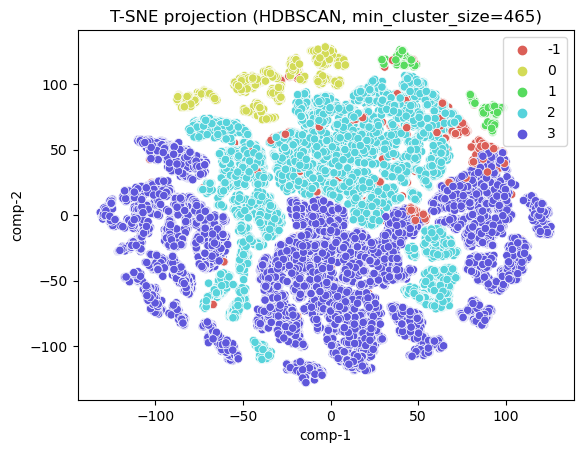

In [51]:
plot_hdbscan(465,3)

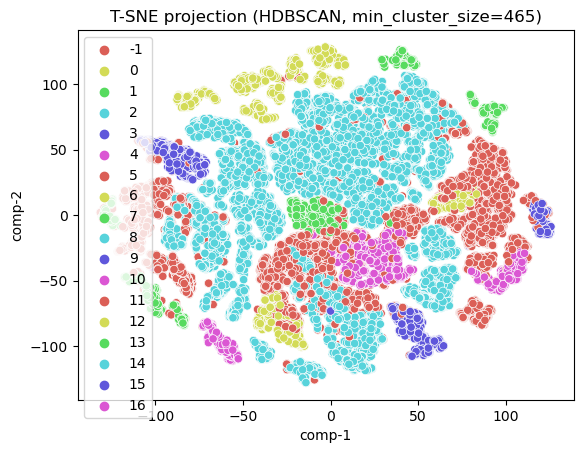

In [56]:
plot_hdbscan(465,2)

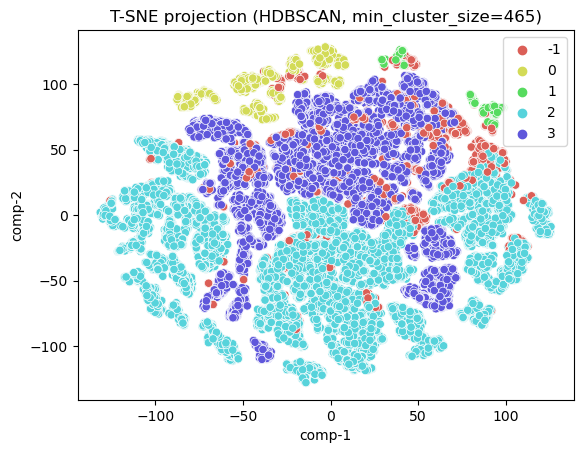

In [59]:
plot_hdbscan(465,20)

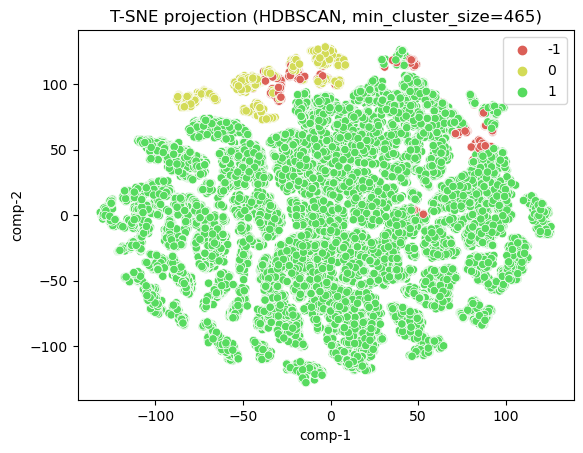

In [66]:
plot_hdbscan(465,40)

### HDBSCAN with Gower Distance

In [173]:
df_num = dfp.select_dtypes(exclude='object')
df_cat = dfp.select_dtypes(include='object')

# Select only categorical columns that contain less than 50% NO_DATA values
# PROVINCE is not included anymore because of REGION
df_cat_selected = df_cat[['REGION', 'EDUCATION', 'BUSINESS_OWNER', 'DIGITAL_FLAG', 'INCOME_SOURCE', 'GENDER', 'MARITAL_STATUS']]

# Standard scale
for c in df_num.columns:
    df_num.loc[:, c] = StandardScaler().fit_transform(np.array(df_num[c]).reshape(-1, 1))

In [175]:
# Apply PCA on numerical cols

pca = PCA(n_components=10)
res_pca = pca.fit_transform(df_num)

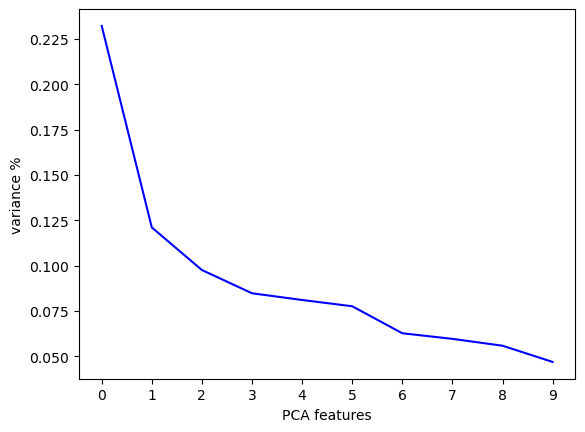

In [176]:
features = range(pca.n_components_)
plt.plot(features, pca.explained_variance_ratio_, color='blue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

By elbow method, we choose n=3

In [177]:
pca_final = PCA(n_components=3)
res_pca = pca_final.fit_transform(df_num)
df_num_pca = pd.DataFrame(res_pca)

In [182]:
dfp_combined = pd.concat([df_num_pca, df_cat_selected], axis=1)
dfp_combined.columns = [i for i in range(10)]

,0,1,2,3,4,5,6,7,8,9
0,2.988560,-1.390256,-0.612221,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,N,DIGITAL,ALLOWANCE,MALE,SINGLE
1,-0.823793,-1.311116,0.330586,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,N,NO_DATA,SALARY,FEMALE,SINGLE
2,0.648351,-1.181800,-0.508830,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,N,TRADITIONAL,ALLOWANCE,MALE,SINGLE
3,-0.712409,-1.463860,0.285710,CORDILLERA ADMINISTRATIVE REGION (CAR),LOW,N,TRADITIONAL,ALLOWANCE,MALE,SINGLE
4,0.336836,-1.518471,-0.139461,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,N,DIGITAL,SALARY,FEMALE,SINGLE


I want to test using a fraction of my dataset first.

In [183]:
import gower

df_small = dfp_combined.sample(4000)
matrix = gower.gower_matrix(df_small)

In [191]:
import hdbscan

model = hdbscan.HDBSCAN(min_cluster_size=23, min_samples=3, metric='precomputed')
clusters = model.fit_predict(matrix.astype('float64'))
np.unique(clusters)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22], dtype=int64)

In [193]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

tsne = TSNE(n_components=2)

df_small_num = df_small.select_dtypes(exclude='object')
df_small_cat = df_small.select_dtypes(include='object')

for column in df_small_cat.columns:
    df_small_cat[column] = LabelEncoder().fit_transform(df_small_cat[column])

df_small_tsne = pd.concat([df_small_num, df_small_cat], axis=1)
df_small_tsne.columns = [i for i in range(len(df_small_tsne.columns))]
test_transformed = tsne.fit_transform(df_small_tsne)

In [196]:
import seaborn as sns

def plot_hdbscan(n,s, my_df, my_matrix, tsne_obj,my_metric='euclidean'):
    test_df = my_df.copy()
    
    model = hdbscan.HDBSCAN(min_cluster_size = n, min_samples= s, metric=my_metric)
    clusters = model.fit_predict(my_matrix.astype('float64'))

    test_df.insert(0, 'CLUSTER', clusters)

    # plot
    test_hdbscan = pd.DataFrame()
    test_hdbscan['CLUSTER'] = test_df['CLUSTER']
    test_hdbscan['comp-1'] = tsne_obj[:,0]
    test_hdbscan['comp-2'] = tsne_obj[:,1]
    
    sns.scatterplot(x="comp-1", y="comp-2", hue=test_hdbscan.CLUSTER.tolist(),
                    palette=sns.color_palette('hls'),
                    data=test_hdbscan).set(title=f"T-SNE projection (HDBSCAN n=4000, min_cluster_size={n})")
    plt.show()

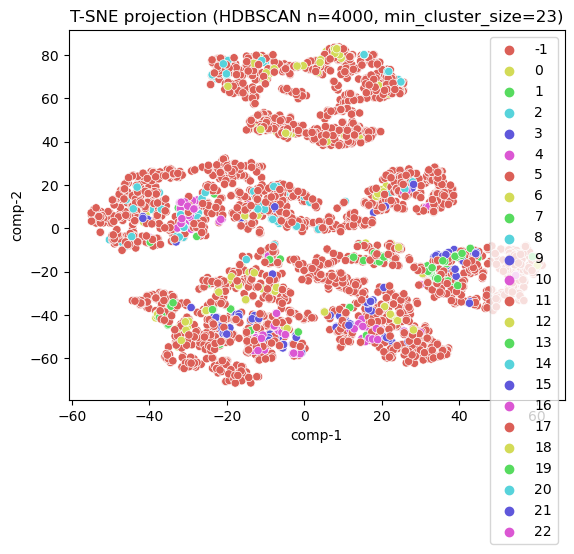

In [218]:
plot_hdbscan(23, 3, df_small, matrix, test_transformed, 'precomputed')

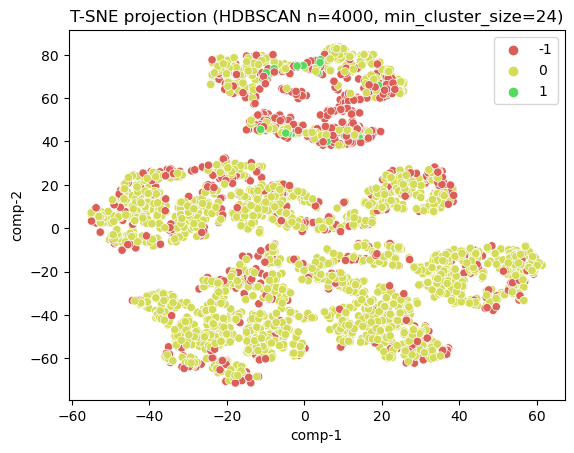

In [222]:
plot_hdbscan(24, 3, df_small, matrix, test_transformed, 'precomputed')

I want to repeat this testing process but using the original `dfp_pca` where one-hot encoding was applied to the categorical features then reduced using PCA.

In [136]:
df_small_orig = dfp_pca.sample(4000)

In [137]:
df_small_orig 

,0,1,2,3,4
42108,7.895873,2.382262,2.046827,-1.422792,-0.884964
35174,-1.354986,-0.283521,0.926267,-1.421714,1.167877
28165,-0.325809,-1.735182,-1.153524,-1.931768,1.168070
10250,-2.735634,0.012366,1.047527,0.694781,1.768217
40341,-1.243150,-1.187316,-0.179195,-1.316786,-1.291209
...,...,...,...,...,...
21534,0.186367,-1.162254,-0.237238,1.089579,0.424495
21581,4.674518,1.421088,1.347674,0.289600,-1.325679
16368,0.862323,-1.320677,-1.710501,0.842738,-1.750408
3617,-1.616890,-0.046045,0.364086,1.479907,-1.421669


In [140]:
matrix2 = gower.gower_matrix(df_small_orig)

In [141]:
test2_transformed = tsne.fit_transform(df_small_orig)

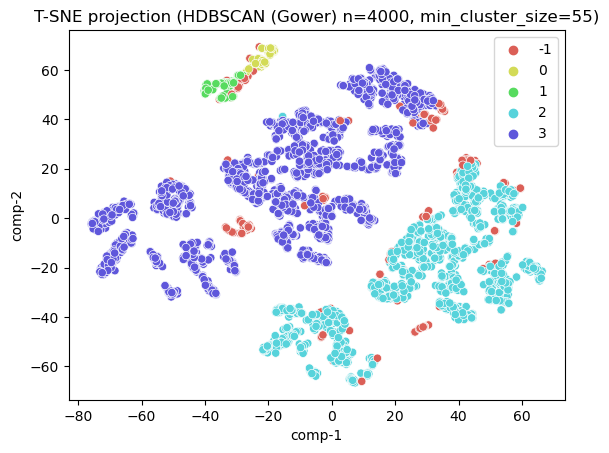

In [164]:
plot_hdbscan(55,3, df_small_orig, matrix2, test2_transformed, 'precomputed')

I want to compare this when the HDBSCAN distance metric is Euclidean.

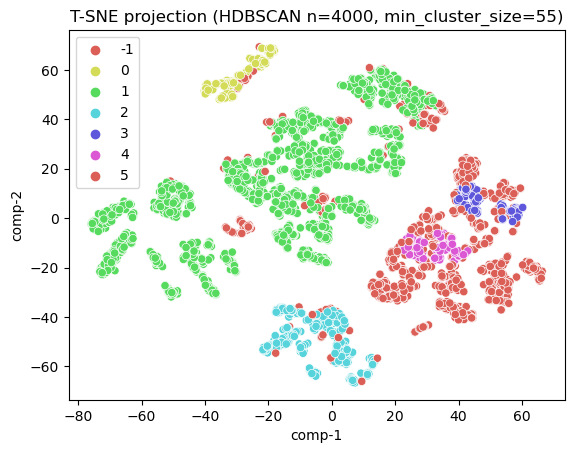

In [168]:
plot_hdbscan(55,3, df_small_orig, df_small_orig, test2_transformed, 'euclidean')

Observation: using euclidean as the distance metric produces more noise when used with the same parameters

Current progress:
- Best HDBSCAN yet is with euclidean measure on dataset applied with one-hot encoding and PCA.
- Problems using HDBSCAN with gower: (1) very long computation time for both gower and creating the HDBSCAN model itself, (2) hard to visualize with t-SNE (options include one-hot encoding which creates curse of dimensionality and labelencoding which is not accurate for categorical features such as REGION and INCOME_SOURCE). (3) hyperparameter tuning also becomes difficult due to long fit_transform
- Include as part of limitations and recommendations

Next steps:
- Compare HDBSCAN with manhattan measure on dataset applied with one-hot encoding and PCA.
- Try with increased features (n=7)
- PAM (K-medoids) with manhattan measure on dataset applied with one-hot encoding and PCA.

### HDBSCAN Euclidean vs HDBSCAN Manhattan

In [12]:
import hdbscan

In [13]:
dfp_pca.head()

,0,1,2,3,4
0,3.641638,-0.287821,-2.156419,-0.195593,-0.931609
1,-0.209847,-1.852982,-1.237955,-2.251816,1.284356
2,0.935476,-1.260118,-2.866235,0.948150,-1.277998
3,-0.695634,-1.244114,-2.174255,0.460452,-1.063406
4,2.127946,-1.322556,-1.554582,-1.413003,1.300280


In [15]:
chosen = [465] # derived from playing around with paramaters and visually inspecting the clustering in t-SNE graph

In [16]:
dfp_h = big_df.copy()

model1 = hdbscan.HDBSCAN(min_cluster_size=chosen[0], min_samples=3, metric='euclidean')
clusters1 = model1.fit_predict(dfp_pca.astype(np.float64))

model2 = hdbscan.HDBSCAN(min_cluster_size=chosen[0], min_samples=3, metric='manhattan')
clusters2 = model2.fit_predict(dfp_pca.astype(np.float64))

In [17]:
import numpy as np
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
transformed = tsne.fit_transform(dfp_pca)

In [18]:
hdbscan_euclidean = pd.DataFrame()
hdbscan_euclidean['CLUSTER'] = clusters1
hdbscan_euclidean['comp-1'] = transformed[:,0]
hdbscan_euclidean['comp-2'] = transformed[:,1]

hdbscan_manhattan = pd.DataFrame()
hdbscan_manhattan['CLUSTER'] = clusters2
hdbscan_manhattan['comp-1'] = transformed[:,0]
hdbscan_manhattan['comp-2'] = transformed[:,1]

In [19]:
import seaborn as sns

def plot_hdbscan2(df, title):
    sns.scatterplot(x="comp-1", y="comp-2", hue=df.CLUSTER.tolist(),
                    palette=sns.color_palette('hls'),
                    data=df).set(title=title)
    
    plt.savefig(f'hdbscan/{title}.png')
    plt.show()

    plt.clf()

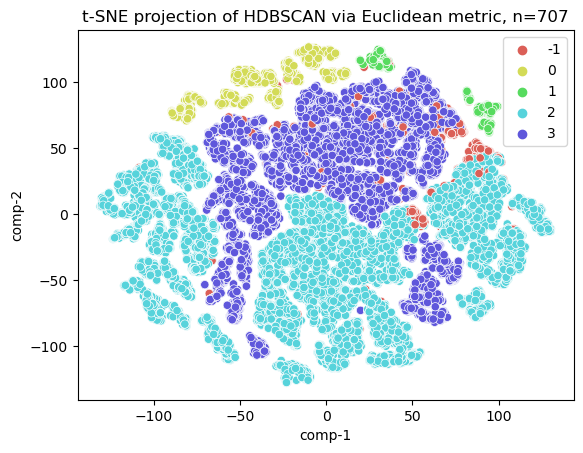

<Figure size 640x480 with 0 Axes>

In [20]:
plot_hdbscan2(hdbscan_euclidean, 't-SNE projection of HDBSCAN via Euclidean metric, n=707')

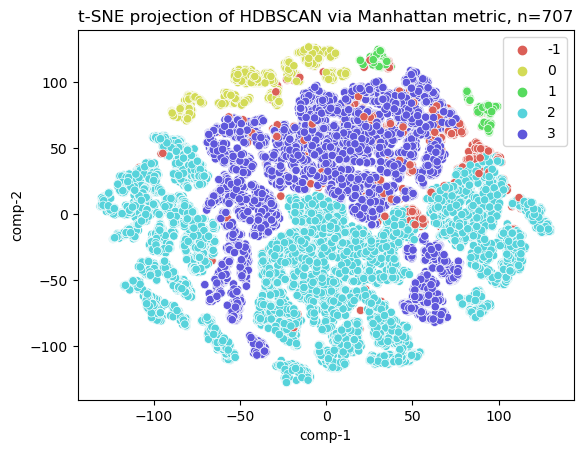

<Figure size 640x480 with 0 Axes>

In [21]:
plot_hdbscan2(hdbscan_manhattan, 't-SNE projection of HDBSCAN via Manhattan metric, n=707')

#### Getting DBCV (density-based cluster validation) scores

In [105]:
import dbcv
# python -m pip install "git+https://github.com/FelSiq/DBCV"

def print_score(df, title):
    df_test = df[['comp-1', 'comp-2', 'CLUSTER']].drop_duplicates()
    X = df_test[['comp-1', 'comp-2']].to_numpy().astype(np.float64)
    score = dbcv.dbcv(X,df_test.CLUSTER.tolist())
    print(f'{title}, score = {score}')

In [106]:
print_score(hdbscan_euclidean, 'HDBSCAN (Euclidean, min_cluster_size=465)')

OSError: [WinError 87] The parameter is incorrect

In [24]:
dfp_h.insert(0, 'CLUSTER_EUCLIDEAN', clusters1)
dfp_h.insert(1, 'CLUSTER_MANHATTAN', clusters2)

In [26]:
dfp_h.head()

,CLUSTER_EUCLIDEAN,CLUSTER_MANHATTAN,CUST_NUM,PROVINCE,REGION,EDUCATION,AGE,TENURE,BUSINESS_OWNER,DIGITAL_FLAG,...,DIGITAL_CHANNEL,DIGITAL_TRAN_TYPE,INCOMING_MEAN,INCOMING_COUNT,INCOMING_BPI_ACCT_TYPE,INCOMING_SRC_BANK_NAME,OUTGOING_MEAN,OUTGOING_COUNT,OUTGOING_CHANNEL,OUTGOING_RCV_BANK_NAME
0,3,3,11712.654012,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,20.0,1.833333,N,DIGITAL,...,MOBILE,BILLS PAYMENT,2619.191451,5.0,SA,HUMAN,1626.116225,17.0,MOBILE,HUMAN
1,2,2,436.605085,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,21.0,4.250000,N,NO_DATA,...,NO_DATA,NO_DATA,0.000000,0.0,NO_DATA,NO_DATA,0.000000,0.0,NO_DATA,NO_DATA
2,3,3,921.989154,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,23.0,2.000000,N,TRADITIONAL,...,WEB,E-WALLET,3349.209339,4.0,SA,HUMAN,0.000000,0.0,NO_DATA,NO_DATA
3,3,3,1119.634762,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),LOW,13.0,5.583333,N,TRADITIONAL,...,NO_DATA,NO_DATA,0.000000,0.0,NO_DATA,NO_DATA,0.000000,0.0,NO_DATA,NO_DATA
4,2,2,1709.755538,BENGUET,CORDILLERA ADMINISTRATIVE REGION (CAR),NO_DATA,20.0,1.250000,N,DIGITAL,...,WEB,E-WALLET,3886.745466,4.0,SA,CAT,0.000000,0.0,NO_DATA,NO_DATA


In [27]:
dfp_h.to_csv('hdbscan_test.csv', index=False)